# Working with Custom Images

Let's explore what its like to work with a more realistic data set.

## The Data

----------
--------

ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches.**

### Visualizing the Data


-------
Let's take a closer look at the data.

In [40]:
# zip_path = base/’size_test/cats_dogs.zip’
# !cp “{zip_path}” .
# !unzip -q cats_dogs.zip
# !rm cats_dogs.zip

In [1]:
#  mounts the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

import zipfile
import os

In [3]:
# drive path
zip_path = '/content/drive/MyDrive/cell_images.rar'

In [4]:
# copying the file from drive to colab
!cp "{zip_path}" .

In [ ]:
# unrar the file
!unrar x cell_images.rar

In [3]:
#!unrar x "/content/drive/MyDrive/cell_images.rar" "/content/drive/MyDrive/Tensorflow"

In [6]:
my_data_dir = '/content/cell_images'

In [7]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['train', 'test']

In [8]:
test_path = my_data_dir+'/test'
train_path = my_data_dir+'/train'

In [9]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [10]:
os.listdir(train_path)

['parasitized', 'uninfected']

**Let's check how many images there are.**

In [11]:
len(os.listdir('/content/cell_images/test/parasitized'))

1300

In [12]:
len(os.listdir('/content/cell_images/test/uninfected'))

1300

In [13]:
len(os.listdir('/content/cell_images/train/parasitized'))

12480

In [14]:
len(os.listdir('/content/cell_images/train/uninfected'))

12480

**Single image.**

In [15]:
os.listdir(train_path+'/parasitized')[0]

'C182P143NThinF_IMG_20151201_172257_cell_188.png'

In [16]:
para_cell = train_path+'/parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [17]:
para_img = imread(para_cell)

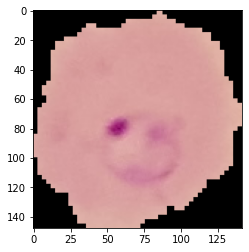

In [18]:
plt.imshow(para_img)
plt.show()

In [19]:
os.listdir(train_path+'/uninfected')[0]

'C145P106ThinF_IMG_20151016_154719_cell_57.png'

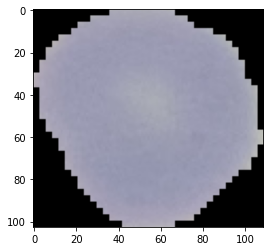

In [20]:
unifected_cell_path = train_path+'/uninfected/'+'/C145P106ThinF_IMG_20151016_154719_cell_57.png'
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)
plt.show()

**The images have differents dimensions. Let's find out the average dimensions of these images.**

In [21]:
para_img.shape

(148, 142, 3)

In [22]:
unifected_cell.shape

(103, 109, 3)

In [23]:
 # Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
 dim1 = []
 dim2 = []

 for image_filename in os.listdir(test_path+'/uninfected'):

   img = imread(test_path+'/uninfected/'+image_filename)
   d1, d2, colors_channel = img.shape
   dim1.append(d1)
   dim2.append(d2)
   

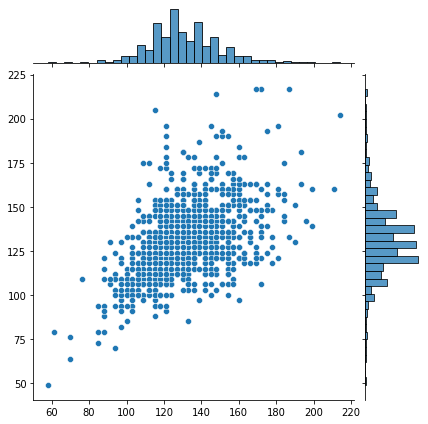

In [24]:
sns.jointplot(x= dim1, y = dim2)
plt.show()

In [25]:
# width pixel mean
np.mean(dim1)

130.92538461538462

In [26]:
# height pixel mean
np.mean(dim2)

130.75

In [27]:
# setting the average image dimension
image_shape = (130,130,3)

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [28]:
para_img.max()

0.9098039

In [29]:
unifected_cell.max()

0.7607843

In [30]:
unifected_cell.min()

0.0

In [31]:
para_img.min()

0.0

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# many way to change the images
help(ImageDataGenerator)

In [33]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               #rescale=1/255, # our data is already scaled.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

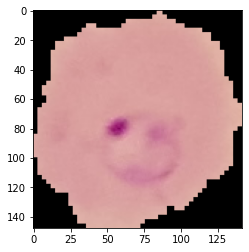

In [34]:
plt.imshow(para_img)
plt.show()

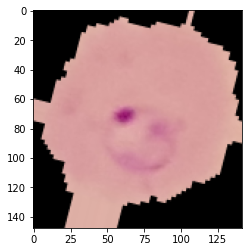

In [35]:
# randomly transforming the image
plt.imshow(image_gen.random_transform(para_img))
plt.show()

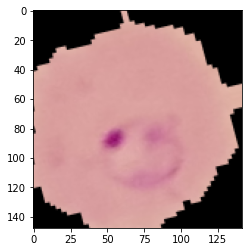

In [36]:
# randomly transforming the image
plt.imshow(image_gen.random_transform(para_img))
plt.show()

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [37]:
# our data is separated in 2 directories
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [38]:
# our data is separated in 2 directories
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [40]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Early Stopping

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [44]:
batch_size = 16

In [46]:
image_shape[:2]

(130, 130)

In [47]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary')

Found 24958 images belonging to 2 classes.


In [48]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [49]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [50]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
results = model.fit_generator(train_image_gen, epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

In [51]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('malaria_detector.h5')